# 쇼핑몰 지점별 매출액 예측 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style='white')

In [3]:
os.getcwd()

'C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측\\쇼핑몰지점별-매출액-EDA모델링'

In [4]:
os.chdir('C:\\Users\\Jaesu\\github_desktop\\Dacon-Basic\\쇼핑몰지점별-매출액-예측')

In [5]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [6]:
df.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

## 데이터 전처리 및 파생변수 생성

- Data 변수를 날짜 형식으로 변경하여 연, 월, 일 변수를 생성

`-` 또한 2010년을 기준으로 연월일을 하루 단위로 변환하여 2010년으로부터 며칠이 지났는지를 알 수 있는 변수를 생성하겠다  

In [7]:
def get_date(df) -> None:
    """df['Date']에서 연, 월, 일 변수를 생성""" 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

In [8]:
get_date(df)
get_date(test)

In [9]:
df['Day_Range'] = (df['Date'] - pd.datetime(2010, 1, 1)).dt.days
test['Day_Range'] = (test['Date'] - pd.datetime(2010, 1, 1)).dt.days

- 한 해의 몇 주차인지 나타내는 변수

In [10]:
df['WeekOfYear'] = df['Date'].dt.weekofyear
test['WeekOfYear'] = test['Date'].dt.weekofyear

- 공휴일 변수를 숫자로 변경

In [11]:
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x else 0)

- 화씨를 섭씨로 변환

In [12]:
df['Temperature'] = (df['Temperature'] - 32) * 5/9
test['Temperature'] = (test['Temperature'] - 32) * 5/9

- 프로모션의 결측치를 $0$으로 대체

In [13]:
df.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

- 총 프로모션 비용 변수 생성

In [14]:
df['Promotion_Cost'] = df[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)
test['Promotion_Cost'] = test[['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']].sum(axis=1)

In [15]:
df.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5'], axis=1, inplace=True)
test.drop(['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5'], axis=1, inplace=True)

- month의 몇 번재 week인지 나타내는 변수 생성

In [16]:
df['WeekOfMonth'] = df['Day'].apply(lambda x: (x-1) // 7 + 1)
test['WeekOfMonth'] = test['Day'].apply(lambda x: (x-1) // 7 + 1)

- 크리스마스가 몇 주일 남았는지 나타내는 변수를 생성

`-` 크리스마스는 12월 4주차에 존재함

`-` 12월 3주차는 2, 4주차는 3, 5주차는 1, 그 외는 0으로 코딩 (매출액이 기준)

In [17]:
def christmas_week(date):
    month = date.month
    week_of_month = (date.day-1) // 7 + 1
    if month == 12:
        if week_of_month == 3:
            return 2
        elif week_of_month == 4:
            return 3
        elif week_of_month == 5:
            return 1
    return 0

In [18]:
df['IsChristmasWeek'] = df['Date'].apply(lambda date: christmas_week(date))
test['IsChristmasWeek'] = test['Date'].apply(lambda date: christmas_week(date))

- 전날에 비해 온도, 연료 가격, 실업률이 얼마나 변했는지 나타내는 변수 생성

<AxesSubplot:>

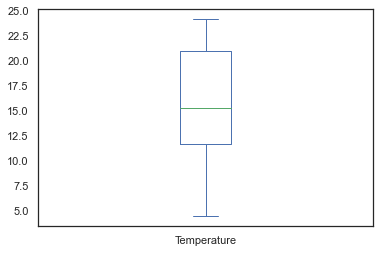

In [19]:
test.query('Month == 10')['Temperature'].plot.box()

In [20]:
date = sorted(df['Date'].unique())

In [136]:
def feature_diff(df, is_test=False) -> None:
    df['Temperature_Diff'] = 0
    df['Fuel_Price_Diff'] = 0
    df['Unemployment_Diff'] = 0
    
    if not is_test:
        for store in tqdm(range(1, 46)):
            for i in range(1, len(date)):
                current_date = date[i]
                previous_date = date[i - 1]
                df_  = df.query('Store == @store')
                for feature in ['Temperature', 'Fuel_Price', 'Unemployment']:
                    df.loc[(df['Store'] == store) & (df['Date'] == current_date), f'{feature}_Diff'] = df_.query('Date == @current_date')[feature].item()\
                                                                                                       - df_.query('Date == @previous_date')[feature].item()
#     else:
#         test_date = sorted(df['Date'].unique())
#         for store in tqdm(range(1, 46)):
#             for test_d in test_date:
#                 current_date = test_d
#                 previous_date = date[0]
#                 for d in date:
#                     if test_d > d:
#                         previous_date = d
#                     else:
#                         break
                        
#                 df_  = df.query('Store == @store')
#                 for feature in ['Temperature', 'Fuel_Price', 'Unemployment']:
#                     df.loc[(df['Store'] == store) & (df['Date'] == current_date), f'{feature}_Diff'] = df_.query('Date == @current_date')[feature].item()\
#                                                                                                        - df_.query('Date == @previous_date')[feature].item()

In [21]:
# feature_diff(df)

In [22]:
df.head()

,Store,Date,Temperature,Fuel_Price,Unemployment,IsHoliday,Weekly_Sales,Year,Month,Day,Day_Range,WeekOfYear,Promotion_Cost,WeekOfMonth,IsChristmasWeek
0,1,2010-05-02,5.727778,2.572,8.106,0,1643690.90,2010,5,2,121,17,0.0,1,0
1,1,2010-12-02,3.616667,2.548,8.106,1,1641957.44,2010,12,2,335,48,0.0,1,0
2,1,2010-02-19,4.405556,2.514,8.106,0,1611968.17,2010,2,19,49,7,0.0,3,0
3,1,2010-02-26,8.127778,2.561,8.106,0,1409727.59,2010,2,26,56,8,0.0,4,0
4,1,2010-05-03,8.055556,2.625,8.106,0,1554806.68,2010,5,3,122,18,0.0,1,0


- 쇼핑몰 지점 군집화

`-` 군집화되는 쇼핑몰이 거의 없어 성능 차이가 없음

In [17]:
cor_list = []
for store in list(range(1, 46)):
    df_ = df.query('Store == @store')
    cor = np.corrcoef(df_['Day_Range'], df_['Weekly_Sales'])[1, 0]
    cor_list.append(cor)

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Count'>

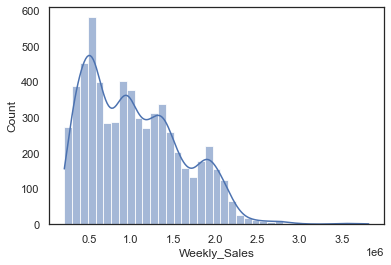

In [18]:
sns.histplot(data=df, x='Weekly_Sales', kde=True)

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

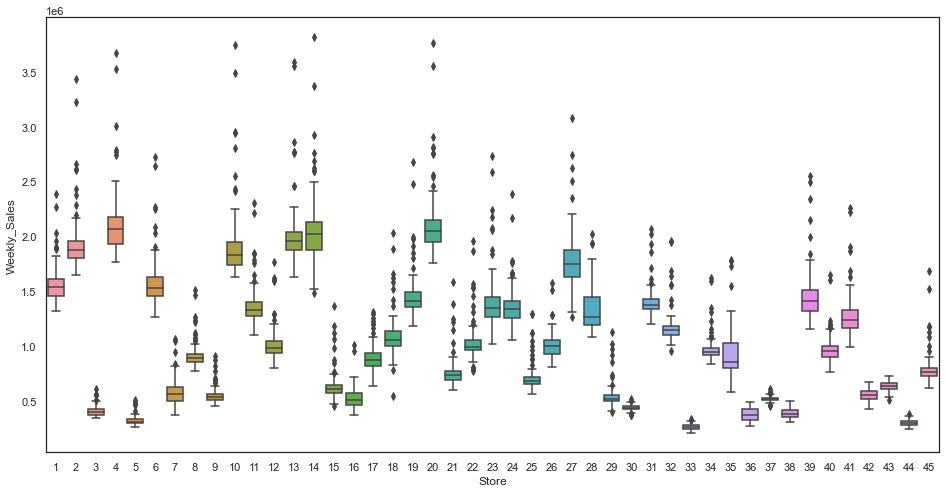

In [19]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df, y='Weekly_Sales', x='Store')

`-` 비슷한 분포를 띄는 쇼핑몰 지점을 군집화하자 (매출액의 중앙값과 IQR, 지난 일수와의 상관계수가 비슷해야 함)

In [18]:
tmp = df.groupby(by='Store').agg({'Weekly_Sales':[np.median, lambda x: np.quantile(x, q=0.75) - np.quantile(x, q=0.25)]}).\
        reset_index().rename(columns={'<lambda_0>':'IQR'}).melt(id_vars='Store').\
        rename(columns={'variable_1':'statistic'}).drop('variable_0', axis=1)

<AxesSubplot:>

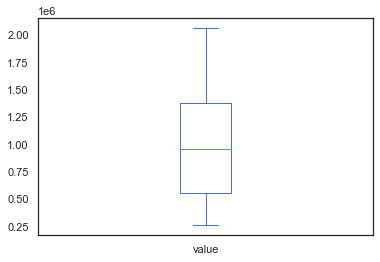

In [21]:
tmp.query('statistic == "median"').value.plot.box()

<AxesSubplot:>

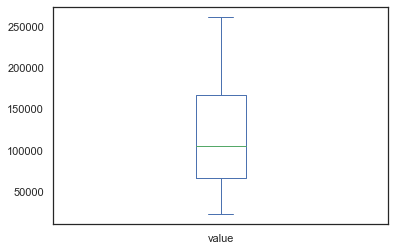

In [22]:
tmp.query('statistic == "IQR"').value.plot.box()

`-` 매출액의 중앙값과 사분위수 범위가 비슷한 쇼핑몰 지점끼리 군집화하겠다

`-` 나의 능지 문제로 일단은 일일이 분류하겠다

`-` 나중에 함수로 만들든 클래스로 만들든 해가지고 이를 사용해 분류하겠다


In [19]:
median_bins = [-np.inf]
for i in range(1, 8):
    value = np.quantile(tmp.query('statistic == "median"').value, q=i/8)
    median_bins.append(value)
median_bins.append(np.inf)

In [20]:
cuts = pd.cut(tmp.query('statistic == "median"').value, bins=median_bins, labels=list(range(1, 9)))

In [21]:
store_df = pd.DataFrame(data=range(1, 46), columns=['Store'])

In [22]:
store_df['Cut'] = cuts

In [23]:
store_df = store_df.merge(tmp.query('statistic == "median"').drop('statistic', axis=1)).\
                    rename(columns={'value':'median'}).\
                    merge(tmp.query('statistic == "IQR"').drop('statistic', axis=1)).\
                    rename(columns={'value':'IQR'})

- 사후처리

`-` 군집내에서 쇼핑몰 지점별 중앙값의 차이가 큰 경우 군집을 쪼개겠다

`-` 또한, 군집내에서 사분위수 범위가 유사한 것끼리 다시 군집화하겠다

`-` 성능을 올리기 위해선 필수이다 (얼마나 올라갈진...)

|군집 번호| 매출액의 범위|쇼핑몰 지점|
|:-:|:-:|:-:|
|1|$<416493$|33, 44, 5, 36, 38, 3|
|2|$<556046$|30, 16, 37, 29, 9 ,42|
|3|$<752464$|7, 15, 43, 25, 21|
|4|$<954233$|45, 35, 17, 8, 34, 40|
|5|$<1191838$|12, 22, 26, 18, 32|
|6|$<1378340$|41, 28, 11, 24, 23, 31|
|7|$<1786338$|19, 39, 6, 1, 27|
|8|$\geq 1786338$|10, 2, 13, 14, 20, 4|

`-` 그룹 8 다시 분류

2와 10, 13, 14, 20, 4

`-` 그룹 7 다시 분류

19, 39, 6,  1, 27

`-` 그룹 6 다시 분류

24, 23, 31, 11과 24, 41, 28

`-` 그룹 5 다시 분류

18, 32, 12, 22, 26

`-` 그룹 4 다시 분류

34와 40, 17, 35, 8

`-` 그룹 3 다시 분류

45(그룹3과 4의 경계)와 21, 25, 43(특별함), 7, 15

`-` 그룹 2 다시 분류

42(특별함), 37(특별함), 30(특별함), 16, 29, 9

`-` 그룹 1 다시 분류

36(하강), 38(상승), 33(특별함), 5, 44

## 모델링

In [23]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [24]:
SEED = 22

In [25]:
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true - pred)))
    return score

In [26]:
def OOF_predict(model, X, y, test, SKfold, stratify=None, original_score=False):
    """
    Out-Of-Fold 방식을 통해 test(numeric)를 예측
    train, valid에 대한 RMSE score와 예측한 test를 return
    """ 
    model_valid_SAE = []
    model_train_score = []
    model_valid_score = []
    model_pred = np.zeros(shape=(test.shape[0]))
    
    if stratify is not None:
        split_fold = SKfold.split(X, X[stratify])
    else:
        split_fold = SKfold.split(X)

    for i, (train_idx, valid_idx) in enumerate(split_fold):
        # print(f'({i + 1} / {SKfold.n_splits}) Fold Training......')
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
        
        ## 모델 적합
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  #eval_metric='rmse', 
                  verbose=0,
                  early_stopping_rounds=200
                 )
        
        ## prediction
        train_pred = model.predict(X_train) ## train
        valid_pred = model.predict(X_valid) ## valid
        test_pred = model.predict(test) ## test
        
        model_train_score.append(RMSE(y_train, train_pred)) ## train RMSE
        model_valid_score.append(RMSE(y_valid, valid_pred)) ## valid RMSE
        model_valid_SAE.extend(np.square(y_valid - valid_pred)) ## square of absolute error
        model_pred += test_pred / SKfold.n_splits ## test 예측값(k Fold)
              
    if original_score:
        return model_train_score, model_valid_score, model_valid_SAE, model_pred
    return model_train_score, model_valid_score, model_pred

`-` 랜덤 포레스트 모델과 그래디언트 부스팅 모델은 성능이 좋지 않았다

In [27]:
RF = RandomForestRegressor(n_estimators=300,
                           max_depth=18,
                           random_state=SEED)

EXT = ExtraTreesRegressor(n_estimators=300,
                           max_depth=18,
                           random_state=SEED)

In [38]:
CB = CatBoostRegressor(n_estimators=5000,
                       learning_rate=0.03,
                       #max_depth=9,
                       use_best_model=True,
                       random_state=SEED,
                       verbose=0)

XGB = XGBRegressor(n_estimators=3000,
                   learning_rate=0.03,
                   max_depth=7,
                   random_state=SEED)

LGBM = LGBMRegressor(n_estimators=3000,
                     learning_rate=0.03,
                     max_depth=7,
                     min_child_samples=2,
                     random_state=SEED)

- Month 변수를 1월, 12월, 그 외 나머지로 구성

In [259]:
# df['Month2'] = df['Month'].apply(lambda x: 0 if x == 1 else (1 if x != 12 else 2))
# test['Month2'] = test['Month'].apply(lambda x: 0 if x == 1 else (1 if x != 12 else 2))

- 사용할 변수

`-` 데이터가 일주일 간격으로 존재하여 `Day` 변수도 추가했다 (하루 간격이었으면 제외했음)

`-` `Day_Range` 변수는 기온에 대한 정보와 날짜 정보를 담고 있다

In [72]:
features = [
            'Store',
            #'Temperature',
            #'Fuel_Price',
            #'Unemployment',
            #'IsHoliday',
            #'Promotion_Cost',
            #'Year',
            'Day',
            'IsChristmasWeek',
            'Month',
            #'Month2',
            'WeekOfYear',
            'WeekOfMonth',
            'Day_Range',
            #'Temperature_Diff'
           ]

In [30]:
target = df['Weekly_Sales']

In [76]:
df2 = df[features] ## 교호작용 X
test2 = test[features]

In [32]:
k = 5
skfold1 = StratifiedKFold(k, shuffle=True, random_state=SEED)
skfold2 = StratifiedKFold(k, shuffle=True, random_state=SEED*2)

- 모델 학습

`-` RF, EXT 모델의 성능은 좋지 않다

- RF

In [67]:
_, RF_valid_RMSE1, RF_test_pred1 = OOF_predict(RF, df2, target, test2, skfold1, stratify='Store')
_, RF_valid_RMSE2, RF_test_pred2 = OOF_predict(RF, df2, target, test2, skfold2, stratify='Store')
print(f'{RF.__class__.__name__} -> Mean: {np.mean(RF_valid_RMSE1 + RF_valid_RMSE2)}, Std: {np.std(RF_valid_RMSE1 + RF_valid_RMSE2)}')

RandomForestRegressor -> Mean: 109924.91976758649, Std: 10244.769607843862


- EXT

In [71]:
_, EXT_valid_RMSE1, EXT_test_pred1 = OOF_predict(EXT, df2, target, test2, skfold1, stratify='Store')
_, EXT_valid_RMSE2, EXT_test_pred2 = OOF_predict(EXT, df2, target, test2, skfold2, stratify='Store')
print(f'{EXT.__class__.__name__} -> Mean: {np.mean(EXT_valid_RMSE1 + EXT_valid_RMSE2)}, Std: {np.std(EXT_valid_RMSE1 + EXT_valid_RMSE2)}')

ExtraTreesRegressor -> Mean: 145061.73794414362, Std: 12217.784447607528


- CB

In [57]:
_, CB_valid_RMSE1, CB_test_pred1 = OOF_predict(CB, df2, target, test2, skfold1, stratify='Store')
_, CB_valid_RMSE2, CB_test_pred2 = OOF_predict(CB, df2, target, test2, skfold2, stratify='Store')
print(f'{CB.__class__.__name__} -> Mean: {np.mean(CB_valid_RMSE1 + CB_valid_RMSE2)}, Std: {np.std(CB_valid_RMSE1 + CB_valid_RMSE2)}')

CatBoostRegressor -> Mean: 79738.92763592312, Std: 5731.959478252804


- XGB

In [60]:
_, XGB_valid_RMSE1, XGB_test_pred1 = OOF_predict(XGB, df2, target, test2, skfold1, stratify='Store')
_, XGB_valid_RMSE2, XGB_test_pred2 = OOF_predict(XGB, df2, target, test2, skfold2, stratify='Store')
print(f'{XGB.__class__.__name__} -> Mean: {np.mean(XGB_valid_RMSE1 + XGB_valid_RMSE2)}, Std: {np.std(XGB_valid_RMSE1 + XGB_valid_RMSE2)}')

XGBRegressor -> Mean: 94365.03624550627, Std: 10254.552883121767


- LGBM

In [180]:
_, LGBM_valid_RMSE1, LGBM_test_pred1 = OOF_predict(LGBM, df2, target, test2, skfold1, stratify='Store')
_, LGBM_valid_RMSE2, LGBM_test_pred2 = OOF_predict(LGBM, df2, target, test2, skfold2, stratify='Store')
print(f'{LGBM.__class__.__name__} -> Mean: {np.mean(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}, Std: {np.std(LGBM_valid_RMSE1 + LGBM_valid_RMSE2)}')

LGBMRegressor -> Mean: 79685.80568992576, Std: 7307.979991065404


`-` LGBM 모델의 성능이 가장 우수하다

- test 예측 및 제출

`-` test 데이터의 경우 행이 180개로 train 데이터에 비해 매우 적다

`-` 연도는 2012년만 존재하며 월의 경우 5월, 10월, 12월만 존재한다

`-` 오버피팅을 주의해야 한다

`-` LGBM 모델과 XGB 모델은 성능이 좋지 않았으며 Catboost 모델의 성능은 나쁘지 않다

In [142]:
submission['Weekly_Sales'] = (CB_test_pred1 + CB_test_pred2) / 2
submission.head()

,id,Weekly_Sales
0,1,1.629705e+06
1,2,1.556559e+06
2,3,1.258371e+06
3,4,1.271491e+06
4,5,1.837574e+06


<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

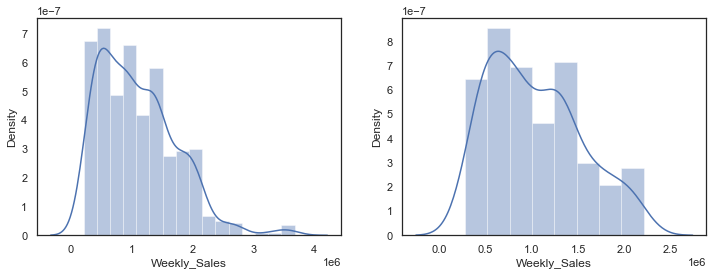

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.query('Year == 2011 and (Month == 5 or Month == 10 or Month == 12)')['Weekly_Sales'], ax=ax1)
sns.distplot(submission['Weekly_Sales'], ax=ax2)

In [403]:
# submission.to_csv('./Data/submission5.csv', index=False)

## 쇼핑몰 지점별 모델 생성

`-` 쇼핑몰마다 주간 매출액의 분포가 상이하여 비슷한 분포를 띄는 쇼핑몰끼리 그룹화하려고 했다

`-` 그런데 굳이 그룹화 하지않고 쇼핑몰 지점에 따른 모델을 생성하여 학습하고자 했다 

`-` 원핫인코딩을 사용하면 피쳐의 개수가 너무 많아져서 쇼핑몰 지점마다 모델을 생성

`-` 기존의 존재하지 않는 새로운 쇼핑몰이라면 전체 데이터로 학습시킨 모델을 사용했다

`-` 그러나 test 데이터에서 새로운 쇼핑몰은 등장하지 않았다

In [60]:
k = 10
skfold1 = KFold(k, shuffle=True, random_state=SEED+2)
#skfold2 = KFold(k, shuffle=True, random_state=SEED*2)

In [71]:
CB = CatBoostRegressor(n_estimators=5000,
                       learning_rate=0.03,
                       max_depth=6,
                       use_best_model=True,
                       random_state=SEED,
                       verbose=0)

In [74]:
XGB = XGBRegressor(n_estimators=3000,
                   learning_rate=0.03,
                   max_depth=6,
                   random_state=SEED)

In [73]:
LGBM = LGBMRegressor(n_estimators=5000,
                     learning_rate=0.03,
                     max_depth=6,
                     min_child_samples=3,
                     random_state=SEED)

In [77]:
valid_RMSE = []
valid_SAE = []
preds = {}
model = XGB
for store in tqdm(range(1, 46)):
    df3 = df.query('Store == @store')
    target = df3['Weekly_Sales']
    df3 = df3[features].drop('Store', axis=1)
    test3 = test2.query('Store == @store')
    test3 = test3[features].drop('Store', axis=1)
    _, model_valid_RMSE, model_valid_SAE, model_test_pred = OOF_predict(model, df3, target, test3, skfold1, original_score=True)
    #_, model_valid_RMSE2, model_valid_SAE2, model_test_pred2 = OOF_predict(model, df3, target, test3, skfold2, original_score=True)
    
    valid_RMSE.extend(model_valid_RMSE 
                      #+ model_valid_RMSE2
                     )
    valid_SAE.extend(model_valid_SAE 
                     #+ model_valid_SAE2
                    )
    preds[store] = model_test_pred 
    print(f'{store} -> Mean: {np.mean(model_valid_RMSE)} Std: {np.std(model_valid_RMSE)}')

print(f'쇼핑몰 지점별 RMSE의 평균: {np.mean(valid_RMSE)}')
print(f'모델의 RMSE: {np.sqrt(np.mean(valid_SAE))}')

  2%|█▊                                                                                 | 1/45 [00:09<07:13,  9.85s/it]

1 -> Mean: 71882.48992936092 Std: 15167.184935794234


  4%|███▋                                                                               | 2/45 [00:20<07:27, 10.40s/it]

2 -> Mean: 93215.30327652217 Std: 25362.4224854352


  7%|█████▌                                                                             | 3/45 [00:28<06:32,  9.35s/it]

3 -> Mean: 22695.982978421285 Std: 3294.0601605764114


  9%|███████▍                                                                           | 4/45 [00:43<07:44, 11.32s/it]

4 -> Mean: 99986.2488301826 Std: 18670.604486872355


 11%|█████████▏                                                                         | 5/45 [00:57<08:10, 12.27s/it]

5 -> Mean: 16580.20571696024 Std: 3466.41766633691


 13%|███████████                                                                        | 6/45 [01:11<08:32, 13.14s/it]

6 -> Mean: 75016.58340494471 Std: 19736.246175407774


 16%|████████████▉                                                                      | 7/45 [01:23<08:06, 12.80s/it]

7 -> Mean: 50015.73241235196 Std: 14863.280393182062


 18%|██████████████▊                                                                    | 8/45 [01:44<09:27, 15.33s/it]

8 -> Mean: 46253.56833454028 Std: 14044.243208678063


 20%|████████████████▌                                                                  | 9/45 [01:57<08:43, 14.55s/it]

9 -> Mean: 30295.68115740446 Std: 8260.614478233116


 22%|██████████████████▏                                                               | 10/45 [02:07<07:36, 13.05s/it]

10 -> Mean: 121991.3740357807 Std: 40855.54052085991


 24%|████████████████████                                                              | 11/45 [02:16<06:41, 11.82s/it]

11 -> Mean: 81567.1957538433 Std: 14942.234719589182


 27%|█████████████████████▊                                                            | 12/45 [02:23<05:47, 10.54s/it]

12 -> Mean: 57484.12257887311 Std: 14144.135903607626


 29%|███████████████████████▋                                                          | 13/45 [02:36<05:58, 11.21s/it]

13 -> Mean: 100985.03412245498 Std: 21771.807000630975


 31%|█████████████████████████▌                                                        | 14/45 [02:45<05:21, 10.36s/it]

14 -> Mean: 149246.25720111016 Std: 45537.13190219465


 33%|███████████████████████████▎                                                      | 15/45 [02:57<05:25, 10.87s/it]

15 -> Mean: 41764.72964973625 Std: 12014.608676740592


 36%|█████████████████████████████▏                                                    | 16/45 [03:06<04:59, 10.31s/it]

16 -> Mean: 33273.916007217085 Std: 7658.3698263223505


 38%|██████████████████████████████▉                                                   | 17/45 [03:15<04:41, 10.05s/it]

17 -> Mean: 73366.49648637022 Std: 24439.64475203209


 40%|████████████████████████████████▊                                                 | 18/45 [03:24<04:20,  9.64s/it]

18 -> Mean: 86618.33260134855 Std: 30724.606001069165


 42%|██████████████████████████████████▌                                               | 19/45 [03:34<04:18,  9.93s/it]

19 -> Mean: 80818.00936821727 Std: 21706.76034486681


 44%|████████████████████████████████████▍                                             | 20/45 [03:44<04:04,  9.80s/it]

20 -> Mean: 117541.2810648594 Std: 32845.421641363806


 47%|██████████████████████████████████████▎                                           | 21/45 [03:55<04:04, 10.18s/it]

21 -> Mean: 54880.87154021376 Std: 15000.493065315572


 49%|████████████████████████████████████████                                          | 22/45 [04:04<03:43,  9.73s/it]

22 -> Mean: 61106.00829720874 Std: 18420.61733404778


 51%|█████████████████████████████████████████▉                                        | 23/45 [04:11<03:19,  9.08s/it]

23 -> Mean: 98779.42935286502 Std: 23651.192633874907


 53%|███████████████████████████████████████████▋                                      | 24/45 [04:19<03:00,  8.58s/it]

24 -> Mean: 81127.49451064374 Std: 17586.086723445216


 56%|█████████████████████████████████████████████▌                                    | 25/45 [04:27<02:51,  8.55s/it]

25 -> Mean: 37859.55520030216 Std: 11592.373883521897


 58%|███████████████████████████████████████████████▍                                  | 26/45 [04:38<02:58,  9.38s/it]

26 -> Mean: 47928.52015355552 Std: 12442.765513141785


 60%|█████████████████████████████████████████████████▏                                | 27/45 [04:45<02:35,  8.65s/it]

27 -> Mean: 129251.43469520446 Std: 45914.142265354916


 62%|███████████████████████████████████████████████████                               | 28/45 [04:55<02:30,  8.84s/it]

28 -> Mean: 73767.20478302614 Std: 17032.450424000628


 64%|████████████████████████████████████████████████████▊                             | 29/45 [05:02<02:15,  8.45s/it]

29 -> Mean: 41226.82571188348 Std: 10747.790914912315


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [05:08<01:53,  7.56s/it]

30 -> Mean: 16567.52906962001 Std: 2841.4568315476313


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [05:18<01:59,  8.55s/it]

31 -> Mean: 53673.4189968471 Std: 10657.866943302204


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [05:27<01:50,  8.48s/it]

32 -> Mean: 49704.852785304865 Std: 9492.03917058759


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [05:36<01:44,  8.71s/it]

33 -> Mean: 12623.728154658826 Std: 3346.21652997485


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [05:44<01:34,  8.57s/it]

34 -> Mean: 38622.19215681681 Std: 10079.474799462196


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [05:51<01:19,  7.97s/it]

35 -> Mean: 88506.91654598582 Std: 15500.513248997659


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [06:01<01:16,  8.54s/it]

36 -> Mean: 17688.093498036054 Std: 3425.858107078863


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [06:07<01:01,  7.73s/it]

37 -> Mean: 14207.623931454164 Std: 2304.796468124682


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [06:14<00:54,  7.78s/it]

38 -> Mean: 14973.31052969858 Std: 3566.1804376022255


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [06:25<00:51,  8.60s/it]

39 -> Mean: 87520.81987831557 Std: 21348.792355267025


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [06:37<00:47,  9.49s/it]

40 -> Mean: 45059.69447606895 Std: 9207.793182914225


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [06:57<00:50, 12.69s/it]

41 -> Mean: 72024.39405747641 Std: 22288.73383412199


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [07:16<00:44, 14.70s/it]

42 -> Mean: 18281.57327976748 Std: 4621.863139703148


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [07:25<00:25, 12.89s/it]

43 -> Mean: 28580.42531605278 Std: 5270.071725940069


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [07:34<00:11, 11.78s/it]

44 -> Mean: 10918.448921386394 Std: 2614.5933323981376


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [07:45<00:00, 10.35s/it]

45 -> Mean: 48246.9552076969 Std: 15564.082084212756
쇼핑몰 지점별 RMSE의 평균: 59860.57479912421
모델의 RMSE: 71599.23746431962


In [78]:
predictions = pd.DataFrame(data=preds[1])
for i in range(2, 46):
    predictions = predictions.append(pd.DataFrame(data=preds[i]))
predictions = predictions.reset_index().drop('index', axis=1).rename(columns={0:'target'})

In [79]:
submission['Weekly_Sales'] = predictions['target'] 

<AxesSubplot:xlabel='Weekly_Sales', ylabel='Density'>

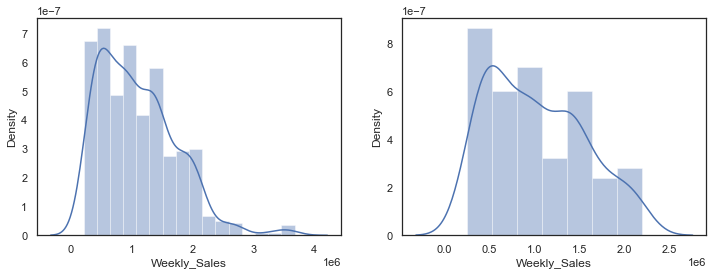

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.query('Year == 2011 and (Month == 5 or Month == 10 or Month == 12)')['Weekly_Sales'], ax=ax1)
sns.distplot(submission['Weekly_Sales'], ax=ax2)

In [82]:
# submission.to_csv('./Data/submission21.csv', index=False)